In [7]:
import tensorflow as tf
import os
import json
import functools
import pyvista as pv
import numpy as np
from utils import *

In [8]:
def plot_graph(data, l=1, plotter=None, node_colors=None):
    
    c = ['r', 'g', 'b', 'm']
    
    p = pv.Plotter() if plotter is None else plotter
    
    # Création d'un PolyData pour les points (nœuds)
    mesh = pv.PolyData()
    
    # Gestion des dimensions des positions
    if data.pos.shape[1] != 3:
        # Ajouter une troisième dimension si nécessaire
        mesh.points = np.concatenate([data.pos.cpu().numpy(), np.full((data.pos.shape[0], 1), l)], axis=1)
    else:
        mesh.points = data.pos.cpu().numpy()

    # Création des lignes pour les arêtes
    edges = data.edge_index.t().cpu().numpy()
    lines = np.hstack([np.full((edges.shape[0], 1), 2), edges]).ravel()
    mesh.lines = lines
    
    
    # Ajout des couleurs au PolyData
    mesh.point_data['values'] = node_colors if node_colors is not None else np.random.randint(0, 255, size=(data.pos.shape[0], 3))
    
    # Ajouter le mesh avec les couleurs des nœuds
    p.add_mesh(mesh, scalars='values', line_width=0.5, point_size=0.3, render_points_as_spheres=True)

    # Si aucun plotter n'a été fourni, on montre la figure
    if plotter is None:
        p.show()

In [9]:
def _parse(proto, meta):
  """Parses a trajectory from tf.Example."""
  feature_lists = {k: tf.io.VarLenFeature(tf.string)
                   for k in meta['field_names']}
  features = tf.io.parse_single_example(proto, feature_lists)
  out = {}
  for key, field in meta['features'].items():
    data = tf.io.decode_raw(features[key].values, getattr(tf, field['dtype']))
    data = tf.reshape(data, field['shape'])
    if field['type'] == 'static':
      data = tf.tile(data, [meta['trajectory_length'], 1, 1])
    elif field['type'] == 'dynamic_varlen':
      length = tf.io.decode_raw(features['length_'+key].values, tf.int32)
      length = tf.reshape(length, [-1])
      data = tf.RaggedTensor.from_row_lengths(data, row_lengths=length)
    elif field['type'] != 'dynamic':
      raise ValueError('invalid data format')
    out[key] = data
  return out

def load_dataset(path, split):
  """Load dataset."""
  with open(os.path.join(path, 'meta.json'), 'r') as fp:
    meta = json.loads(fp.read())
  ds = tf.data.TFRecordDataset(os.path.join(path, split+'.tfrecord'))
  ds = ds.map(functools.partial(_parse, meta=meta), num_parallel_calls=8)
  ds = ds.prefetch(1)
  return ds

In [10]:
train_ds = load_dataset("../DATA/cylinder_flow", 'train')
val_ds = load_dataset("../DATA/cylinder_flow", 'valid')
test_ds = load_dataset("../DATA/cylinder_flow", 'test')

In [11]:
from torch_geometric.data import Data
import torch
from utils import  DelaunayTransform
from torch_geometric.loader import DataLoader
from sklearn.preprocessing import StandardScaler


In [12]:
import numpy as np

def fit_scaler(ds, scaler):
    """
    Fit the scaler on the dataset. This collects all the data across the dataset and fits the scaler.
    """
    data_to_scale = []
    
    for obs in ds:
        # Collect velocity and pressure (or other relevant features) from the dataset to fit the scaler
        for key, value in obs.items():
            if 'velocity' in key or 'pressure' in key:
                array = value[0].numpy()  # Collect the first time step
                if array.ndim == 1:  # If it's 1D, we add a new axis to make it 2D
                    array = np.expand_dims(array, axis=1)
                data_to_scale.append(array)  # Append the corrected array
    
    # Ensure all arrays have the same number of features (same shape on axis 1)
    min_shape = min([arr.shape[1] for arr in data_to_scale])  # Find the smallest second dimension
    data_to_scale = [arr[:, :min_shape] for arr in data_to_scale]  # Crop arrays to the minimum size
    
    data_to_scale = np.concatenate(data_to_scale, axis=0)  # Concatenate all collected data
    scaler.fit(data_to_scale)  # Fit the scaler on all collected data

def prepare_dataset(ds, scaler, train=False):
    transform = DelaunayTransform()
    dataset = []
    
    for i, obs in enumerate(ds):
        new_obs = {}
        for key, value in obs.items():
            if 'mesh' in key or 'cells' in key or 'node_type' in key:
                key = key.replace('mesh_', '')
                new_obs[key] = torch.Tensor(value[0].numpy())
            else:
                # Apply scaling to the velocity and pressure
                array_x = value[0].numpy().reshape(-1, value[0].shape[-1])  # Reshape the first time step
                array_y = value[-1].numpy().reshape(-1, value[-1].shape[-1])  # Reshape the last time step
                
                # Scale both arrays using the trained scaler
                if array_x.shape[1] == scaler.n_features_in_:
                    x_scaled = scaler.transform(array_x)
                    y_scaled = scaler.transform(array_y)
                else:
                    # Handle case where the number of features doesn't match (e.g., skip or pad the data)
                    x_scaled = array_x  # Keep original if it doesn't match
                    y_scaled = array_y

                new_obs["x_" + key] = torch.Tensor(x_scaled)
                new_obs["y_" + key] = torch.Tensor(y_scaled)

        surf = torch.Tensor((obs['velocity'][0][:] == 0.0).numpy())
        surf = torch.logical_and(surf[:, 0], surf[:, 1])
        x = torch.cat([new_obs['x_velocity'], new_obs['x_pressure'], surf.unsqueeze(1)], dim=1)
        y = torch.cat([new_obs['y_velocity'], new_obs['y_pressure']], dim=1)
        data = transform(Data(pos=new_obs["pos"], surf=surf, x=x, y=y))
        data = generate_coarse_graphs(data, 3, 4)
        dataset.append(data)
    
    data_loader = DataLoader(dataset=dataset, batch_size=1)
    return data_loader

# Create a scaler
scaler = StandardScaler()

# Fit the scaler on the training dataset
fit_scaler(train_ds, scaler)

# Prepare the datasets using the trained scaler
train_loader = prepare_dataset(train_ds, scaler, train=True)
val_loader = prepare_dataset(val_ds, scaler)
test_loader = prepare_dataset(test_ds, scaler)


In [13]:
print(next(iter(train_loader)).x)

tensor([[ 0.0779,  0.0000, -0.0127,  0.0000],
        [ 0.0394,  0.0000,  0.0026,  0.0000],
        [ 0.1001, -0.0809,  0.0387,  0.0000],
        ...,
        [ 0.0000,  0.0000, -1.0093,  1.0000],
        [ 0.0000,  0.0000, -1.1779,  1.0000],
        [ 0.0000,  0.0000, -1.2142,  1.0000]])


In [19]:
import importlib
import utils
importlib.reload(utils)
import my_model
from utils import *

In [20]:
#plot_graph(generate_coarse_graphs(next(iter(data_loader)), R=3, K=4, visualize=True))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

In [30]:
model = my_model.UaMgnn(4, 3, 3, 4, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
model = model.to(device)

In [31]:
def validate(model, loader, device):
    model.eval()
    loss = 0
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            out = model(data)
            loss += torch.nn.functional.mse_loss(out, data.y).item()
    return loss / len(loader)
model.parameters()

<generator object Module.parameters at 0x7b03c0bdfd80>

In [32]:
import matplotlib.pyplot as plt
torch.autograd.set_detect_anomaly(True)
validation_losses = []
train_losses = []
for epoch in range(30):
    loss_av = 0
    i = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        
        if torch.isnan(out).any() or torch.isinf(out).any():
            print("Model output contains NaN or Inf")
            # Optionally, save the problematic data for inspection
            torch.save(data, 'problematic_data.pt')
            break  # Exit the loop or handle appropriately
        
        loss = torch.nn.functional.mse_loss(out, data.y)
        
        if torch.isnan(loss) or torch.isinf(loss):
            print("Loss is NaN or Inf")
            break  # Exit the loop or handle appropriately
        
        loss_av += loss.item()
        i += 1
        loss.backward()
        total_norm = 0
        for name, param in model.named_parameters():
            if param.grad is not None:
                param_norm = param.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** 0.5
        print(f"Total gradient norm: {total_norm}")

        # Check gradients for NaN or Inf
        for name, param in model.named_parameters():
            if param.grad is not None:
                if torch.isnan(param.grad).any() or torch.isinf(param.grad).any():
                    print(f"Gradient for {name} contains NaN or Inf")
                    break  # Exit the loop or handle appropriately
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
    train_losses.append(loss_av/i)
    validation_losses.append(validate(model, val_loader, device))
    print(f"Epoch {epoch} Loss {loss_av/i}")
    print(f"Validation Loss {validation_losses[-1]}")
    

Total gradient norm: 1.3512917041191994
Total gradient norm: 1.312543529861423
Total gradient norm: 1.2876071350217866
Total gradient norm: 1.2540346045725224
Total gradient norm: 1.2257306552636218
Total gradient norm: 1.3531466262398162
Total gradient norm: 1.2480618429465975
Total gradient norm: 1.2193710709205765
Total gradient norm: 1.2576334336529895
Total gradient norm: 1.2242783016390593
Total gradient norm: 1.3367122828826743
Total gradient norm: 1.6999399308637753
Total gradient norm: 1.040712211567442
Total gradient norm: 0.8842615790001909
Total gradient norm: 0.5457589023373901
Total gradient norm: 0.4162501558166178
Total gradient norm: 0.4813852573893926
Total gradient norm: 0.5159624049915533
Total gradient norm: 2.3657287346060896
Total gradient norm: 2.5346688061462785
Total gradient norm: 1.3142414093020927
Total gradient norm: 2.1725999477831537
Total gradient norm: 1.6887713312120158
Total gradient norm: 1.3684372595937426
Total gradient norm: 0.5821318398226895
To

In [33]:
validate(model, test_loader, device)

0.01404182069003582

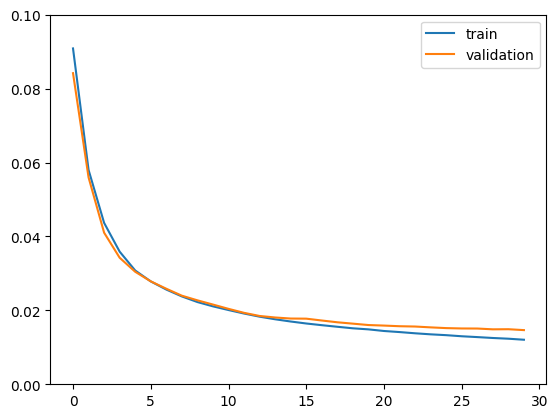

In [34]:
plt.plot(train_losses, label='train')
plt.plot(validation_losses, label='validation')
plt.ylim(0, 0.1)
plt.legend()

In [40]:
data = next(iter(test_loader))
x = data.x
pos = data.pos
y = model(data.to(device)).cpu().detach().numpy()
x.shape, y.shape, pos.shape, data.y.shape

(torch.Size([2728, 4]),
 (1923, 3),
 torch.Size([2728, 2]),
 torch.Size([1923, 3]))

In [41]:
import pandas as pd

df = pd.DataFrame(data={'x': pos[:y.shape[0], 0].numpy(), 'y': pos[:y.shape[0], 1].numpy(), 'u': y[:, 0], 'v': y[:, 1], 'p': y[:, 2]})
df.to_csv('results.csv', index=False)